# Neural Network Classifier x Toxic Content Detection
Il presente Notebook mostra l'addestramento ed il testing di un Classificatore basato su Neural network per il task di Toxic Content Detection.

I dati sono stati processati come segue:
1. Pulizia del testo (si veda, 'dataset_preprocessing.py')
2. Lemmatizzazione con NLTK
3. Vettorizzazione con TF-IDF

In [1]:
import pandas as pd
import pickle
import nltk
import re
import matplotlib.pyplot as plt
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense,Reshape
from keras.optimizers import Adam
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score

C:\Users\Riccardo De Cesaris\AppData\Local\Temp\ipykernel_47176\3088645274.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


All'interno del Notebook saranno addestrate due Reti Neurali, una sul Dataset "non-Lemmatizzato" e l'altra sul Dataset "Lemmatizzato".

In [2]:
# Verifica il dispositivo attualmente utilizzato da TensorFlow
device_name = tf.test.gpu_device_name()

if device_name == '/device:GPU:0':
    print('GPU disponibile, TensorFlow sta utilizzando la GPU.')
else:
    print('GPU non disponibile, TensorFlow sta utilizzando la CPU.')

GPU disponibile, TensorFlow sta utilizzando la GPU.


# Neural Network, Dataset "non-Lemmatizzato"

## Addestramento

In [3]:
training_set = pd.read_csv("./../../datasets/training_set.csv")
print("Numero di Frasi nel Training Set:", len(training_set))
print("Numero Frasi 'toxic' nel Training Set:", len(training_set[training_set['toxic'] == 1]))
print("Numero Frasi 'not-toxic' nel Training Set:", len(training_set[training_set['toxic'] == 0]))

Numero di Frasi nel Training Set: 15282
Numero Frasi 'toxic' nel Training Set: 3058
Numero Frasi 'not-toxic' nel Training Set: 12224


In [4]:
y_train = training_set['toxic']
y_train.shape

(15282,)

In [5]:
# Vettorizzazione con TF-IDF
vectorizer = TfidfVectorizer(dtype=np.float32)

X_train = vectorizer.fit_transform(training_set['comment_text'])
print("X_train.shape: " + str(X_train.shape))

X_train.shape: (15282, 39767)


In [6]:
#CNN model Functional API
review = Input(shape=(X_train.shape[1],), dtype='float', name='review')
# Aggiunta di una dimensione per rappresentare il canale (l'input è bidimensionale e ci aspetta invece la dimensione associata al canale)
review_reshaped = Reshape((X_train.shape[1], 1))(review)
    
# Layer convoluzionali
conv_1 = Conv1D(filters=32, kernel_size=5, activation='relu')(review_reshaped)
max_pool_1 = MaxPooling1D(pool_size=2)(conv_1)
conv_2 = Conv1D(filters=32, kernel_size=3, activation='relu')(max_pool_1)
max_pool_2 = MaxPooling1D(pool_size=2)(conv_2)
conv_3 = Conv1D(filters=64, kernel_size=5, activation='relu')(max_pool_2)

# Appiattimento e strato fully-connected
flatten = Flatten()(conv_3)
main_output = Dense(1, activation='sigmoid', name='main_output')(flatten)

# Costruzione del modello
model = Model(inputs=[review], outputs=[main_output])
    
# Compilazione del modello
optimizer = Adam(lr=1e-2)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 review (InputLayer)         [(None, 39767)]           0         
                                                                 
 reshape (Reshape)           (None, 39767, 1)          0         
                                                                 
 conv1d (Conv1D)             (None, 39763, 32)         192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 19881, 32)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 19879, 32)         3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 9939, 32)         0         
 1D)                                                         

e:\anaconda3\envs\DL_GPU_Full\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [7]:
#CNN model Sequential API
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(X_train.shape[1],), dtype='float'),
        tf.keras.layers.Reshape((X_train.shape[1],1)),
        tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1,activation='sigmoid')
    ]
)

In [8]:
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 39767, 1)          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 39763, 32)         192       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 19881, 32)        0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 19879, 32)         3104      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 9939, 32)         0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 9935, 64)          1

In [ ]:
X_train = X_train.toarray()

# Addestramento sul Dataset non-lemmatizzato
print("Training della Rete Neurale sul Dataset 'non-Lemmatizzato'...")
start = datetime.now()
model.fit(X_train, y_train,epochs=5, batch_size=32)
end = datetime.now()
print("Training completato! Tempo impiegato: " + str(end-start))

model.save("neural_classifier_small.h5")

In [9]:
model = tf.keras.models.load_model("neural_classifier_small.h5")

## Testing

In [10]:
test_data = pd.read_csv("./../../datasets/test_set.csv")
test_data.dropna(inplace=True)

test_set = test_data[test_data['toxic'] != -1]
exp_set = test_data[test_data['toxic'] == -1]

print("Numero di Frasi nel Test Set:", len(test_set))
print("Numero Frasi 'toxic' nel Test Set:", len(test_set[test_set['toxic'] == 1]))
print("Numero Frasi 'not-toxic' nel Test Set:", len(test_set[test_set['toxic'] == 0]))

Numero di Frasi nel Test Set: 63842
Numero Frasi 'toxic' nel Test Set: 6087
Numero Frasi 'not-toxic' nel Test Set: 57755


In [11]:
y_test = test_set['toxic']

In [12]:
X_test = vectorizer.transform(test_set['comment_text'])
print("X_test.shape: " + str(X_test.shape))

X_test.shape: (63842, 39767)


In [13]:
i = 0
predictions = list()
while i < X_test.shape[0]:
    to_submit = X_test[i:i+2500]
    to_test = to_submit.toarray()
    y_pred = model.predict(to_test)
    predictions.append(y_pred)
    i += 2500

    del to_submit
    del to_test
    del y_pred

42/42 [==============================] - 1s 16ms/step


In [14]:
y_pred = np.concatenate(predictions)
y_pred.shape
y_pred_binary = np.where(y_pred > 0.5, 1, 0)

In [15]:
#Metriche: Accuracy,Precision,Recall
print("Accuracy: " + str(accuracy_score(y_test, y_pred_binary)))
print("Precision: " + str(precision_score(y_test, y_pred_binary)))
print("Recall: " + str(recall_score(y_test, y_pred_binary)))
print("F-Measure: " + str(f1_score(y_test, y_pred_binary)))

Accuracy: 0.8605933398076502
Precision: 0.390706348589634
Recall: 0.8260226712666338
F-Measure: 0.5304916649082085


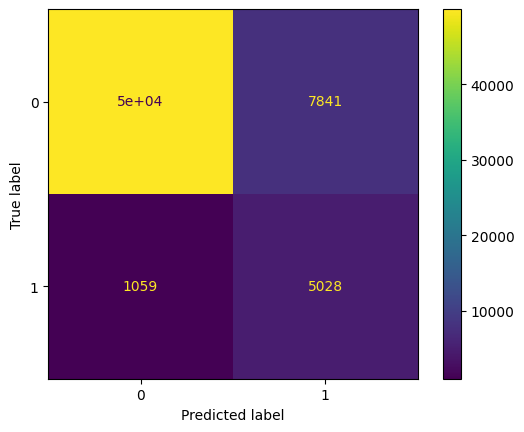

In [16]:
cm = confusion_matrix(y_test, y_pred_binary, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

In [17]:
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred))

ROC-AUC Score: 0.9221436161489357


# Neural Network, Dataset "Lemmatizzato"

In [18]:
tf.keras.backend.clear_session()

## Addestramento

In [19]:
training_set_lem = pd.read_csv("./../../datasets/training_set_lemmatized.csv")

In [20]:
# Vettorizzazione con TF-IDF
vectorizer_lem = TfidfVectorizer(dtype=np.float32)

X_train_lem = vectorizer_lem.fit_transform(training_set_lem['comment_text'])
print("X_train_lem.shape: " + str(X_train_lem.shape))

X_train_lem.shape: (15282, 34238)


In [21]:
#CNN model Functional API
review = Input(shape=(X_train_lem.shape[1],), dtype='float', name='review')
# Aggiunta di una dimensione per rappresentare il canale (l'input è bidimensionale e ci aspetta invece la dimensione associata al canale)
review_reshaped = Reshape((X_train_lem.shape[1], 1))(review)
    
# Layer convoluzionali
conv_1 = Conv1D(filters=32, kernel_size=5, activation='relu')(review_reshaped)
max_pool_1 = MaxPooling1D(pool_size=2)(conv_1)
conv_2 = Conv1D(filters=32, kernel_size=3, activation='relu')(max_pool_1)
max_pool_2 = MaxPooling1D(pool_size=2)(conv_2)
conv_3 = Conv1D(filters=64, kernel_size=5, activation='relu')(max_pool_2)

# Appiattimento e strato fully-connected
flatten = Flatten()(conv_3)
main_output = Dense(1, activation='sigmoid', name='main_output')(flatten)

# Costruzione del modello
model_lem = Model(inputs=[review], outputs=[main_output])
    
# Compilazione del modello
optimizer = Adam(lr=1e-2)
model_lem.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
print(model_lem.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 review (InputLayer)         [(None, 34238)]           0         
                                                                 
 reshape (Reshape)           (None, 34238, 1)          0         
                                                                 
 conv1d (Conv1D)             (None, 34234, 32)         192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 17117, 32)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 17115, 32)         3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 8557, 32)         0         
 1D)                                                         

e:\anaconda3\envs\DL_GPU_Full\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [22]:
#CNN model Sequential API
model_lem = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(X_train_lem.shape[1],), dtype='float'),
        tf.keras.layers.Reshape((X_train_lem.shape[1],1)),
        tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
        tf.keras.layers.MaxPooling1D(pool_size=2),
        tf.keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1,activation='sigmoid')
    ]
)

In [23]:
model_lem.summary()
model_lem.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 34238, 1)          0         
                                                                 
 conv1d_3 (Conv1D)           (None, 34234, 32)         192       
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 17117, 32)        0         
 1D)                                                             
                                                                 
 conv1d_4 (Conv1D)           (None, 17115, 32)         3104      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 8557, 32)         0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 8553, 64)          1

In [ ]:
X_train_lem = X_train_lem.toarray()

# Addestramento sul Dataset non-lemmatizzato
print("Training della Rete Neurale sul Dataset 'non-Lemmatizzato'...")
start = datetime.now()
model_lem.fit(X_train_lem, y_train,epochs=5, batch_size=32)
end = datetime.now()
print("Training completato! Tempo impiegato: " + str(end-start))

model_lem.save("neural_classifier_small_lem.h5")

In [24]:
model_lem = tf.keras.models.load_model("neural_classifier_small_lem.h5")

## Testing

In [25]:
test_data_lem = pd.read_csv("./../../datasets/test_set_lemmatized.csv")
test_data_lem.dropna(inplace=True)

test_set_lem = test_data_lem[test_data_lem['toxic'] != -1]
exp_set_lem = test_data_lem[test_data_lem['toxic'] == -1]

In [26]:
X_test_lem = vectorizer_lem.transform(test_set_lem['comment_text'])
print("X_test_lem.shape: " + str(X_test_lem.shape))

X_test_lem.shape: (63842, 34238)


In [27]:
i = 0
predictions = list()
while i < X_test_lem.shape[0]:
    to_submit = X_test_lem[i:i+2500]
    to_test = to_submit.toarray()
    y_pred = model_lem.predict(to_test)
    predictions.append(y_pred)
    i += 2500

    del to_submit
    del to_test
    del y_pred

42/42 [==============================] - 1s 14ms/step


In [28]:
y_pred_lem = np.concatenate(predictions)
y_pred_lem.shape
y_pred_binary_lem = np.where(y_pred_lem > 0.5, 1, 0)

In [29]:
#Metriche: Accuracy,Precision,Recall
print("Accuracy: " + str(accuracy_score(y_test, y_pred_binary_lem)))
print("Precision: " + str(precision_score(y_test, y_pred_binary_lem)))
print("Recall: " + str(recall_score(y_test, y_pred_binary_lem)))
print("F-Measure: " + str(f1_score(y_test, y_pred_binary_lem)))

Accuracy: 0.8694746405187808
Precision: 0.4072207534699273
Recall: 0.8097585017249876
F-Measure: 0.5419163322522126


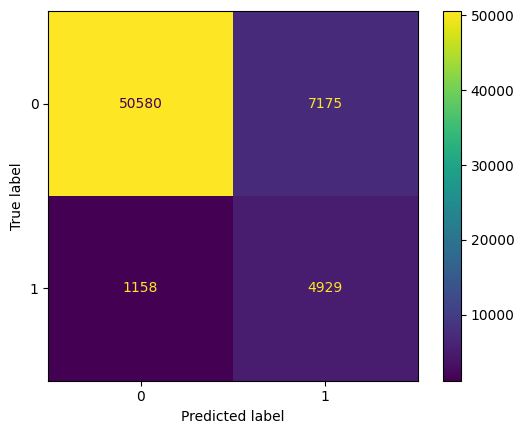

In [30]:
cm = confusion_matrix(y_test, y_pred_binary_lem, labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
plt.show()

In [31]:
print("ROC-AUC Score:", roc_auc_score(y_test, y_pred_lem))

ROC-AUC Score: 0.9209091396406792
